# Auxiliary Classifier GAN (ACGAN)

We have tried:
- Simple GAN
- Conditional GAN (cGAN)
  - Different size of FC
  - Different EPOCH
  - Different learning rate
  - Different batch size
- Conditional Deep Convolutional GAN (cDCGAN)
  - Use Conv in both G and D

We need to try:
- Conditional 'Partial' Convolutional GAN (cPCGAN)
- Use Conv only in D, only FC in G, which may solve the problem.

In [16]:
# -*- coding: utf-8 -*-
from torchvision import transforms
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from sklearn.manifold import TSNE
from time import time
from datetime import datetime
import copy
import seaborn as sns

torch.__version__

torch.manual_seed(42)

trainPath = './fashion-mnist/train.csv' # Path of data
testPath = './fashion-mnist/test.csv' # Path of data

labelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size = 64

learning_rate = 0.0001

# device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
# device = torch.device('cpu')
device = torch.device('mps')

In [17]:
class Sample:
    def __init__(self, idx=0, img=None, feat = None, label=None):
        self.idx = idx
        self.img = img
        self.feat = feat
        self.label = label
        
def loadImage():
    samples = []
    dataCsv = pd.read_csv(trainPath)
    dataCsvImg = dataCsv.drop(columns = 'label')
    dataCsvImg = dataCsvImg.values.astype('uint8')
    
    images = dataCsvImg.reshape(-1, 28, 28)
    labels = dataCsv['label'].values.astype('uint8')
    
    for i in range (len(images)):
        sample = Sample(idx=i, img=images[i], feat = dataCsvImg[i], label=labels[i])
        samples.append(sample)
    return samples, images, labels

allSamples, allImages, allLabels = loadImage()

In [18]:
# You need to implement this by yourself
class FashionDataset(Dataset):
    def __init__(self, inImages, inLabels, transform=None):
        self.transform = transform
        # dataCsv = pd.read_csv(trainPath)
        # dataCsvImg = dataCsv.drop(columns = 'label')
        # dataCsvImg = dataCsvImg.values.astype('uint8')
        self.images = inImages
        self.labels = inLabels
       
    def __len__(self):
       return len(self.images)
    
    def __getitem__(self, idx):
        img = self.transform(Image.fromarray(self.images[idx]))
        label = self.labels[idx]
        return img, label

# transform = transforms.ToTensor()
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])
train = FashionDataset(allImages, allLabels, transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


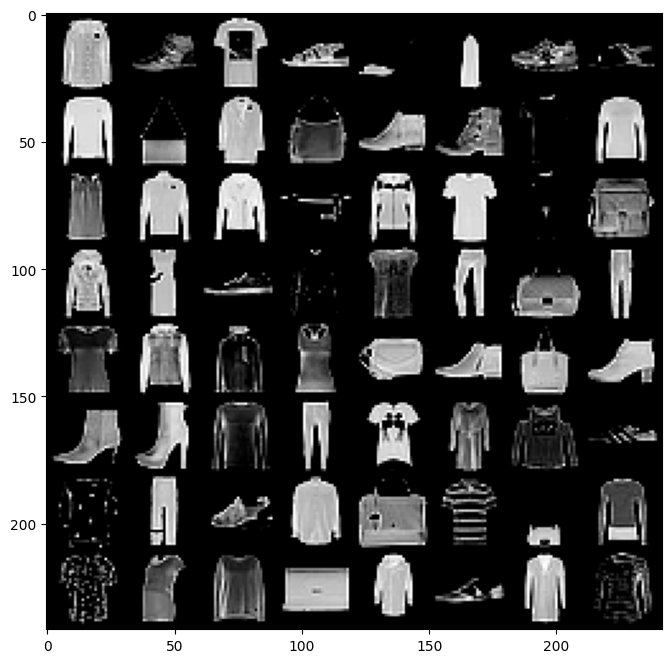

In [19]:
## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(make_grid(images[0:64],nrow=8))

In [20]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        self.label_embed = nn.Embedding(10,100)
        
        self.model = nn.Sequential(
            # 100 1 1
            nn.ConvTranspose2d(100,512,4,1,0,bias = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 512 4 4
            nn.ConvTranspose2d(512,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 256 8 8
            nn.ConvTranspose2d(256,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 128 16 16
            nn.ConvTranspose2d(128,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 64 32 32
            nn.ConvTranspose2d(64,1,4,2,1,bias = False),
            nn.Flatten(),
            # 1 64 64
            nn.Linear(1*64*64, 1*28*28),
            # 1 28 28
            nn.Tanh()
        )
    
    def forward(self,X,label):
        label = self.label_embed(label)
        x = torch.mul(X,label)
        x = x.view(-1,100,1,1)
        x = self.model(x)
        return x.view(-1,1,28,28)
        

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()        
        
        self.model = nn.Sequential(
            # 1 28 28
            nn.Conv2d(1,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Dropout2d(0.5),
            
            # 64 14 14
            nn.Conv2d(64,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Dropout2d(0.5) 
            # 128 7 7
        )
        
        self.D_layer = nn.Sequential(
            nn.Conv2d(128,1,7,1,0,bias = False), 
            # 128 7 7 -> 1                                   
            nn.Sigmoid())
        
        self.label_layer = nn.Sequential(
            nn.Conv2d(128,11,7,1,0,bias = False),
            # 128 7 7 -> 11
            nn.LogSoftmax(dim = 1))
        
    def forward(self,X):
        x = self.model(X)        
        dis = self.D_layer(x).view(-1)
        label = self.label_layer(x).view(-1,11)
        return dis,label

In [21]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

G = Generator().to(device)
# G.apply(weights_init)

D = Discriminator().to(device)
# D.apply(weights_init)
        
optimG = optim.Adam(G.parameters(), 0.0002, betas = (0.5,0.999))
optimD = optim.Adam(D.parameters(), 0.0002, betas = (0.5,0.999))

G_criterion = nn.BCEWithLogitsLoss()
D_criterion = nn.NLLLoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)


EPOCH 001 finalized: discriminator loss 0.003130 - gererator loss 0.003492, time 104.794690s


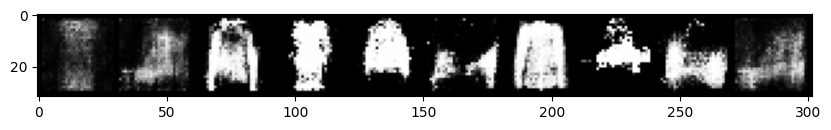

EPOCH 002 finalized: discriminator loss 0.003658 - gererator loss 0.002398, time 207.624953s


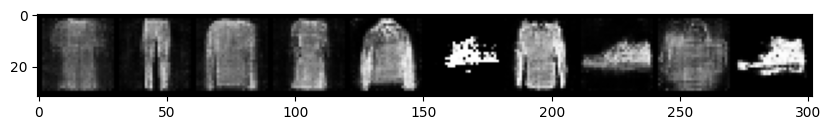

EPOCH 003 finalized: discriminator loss 0.003618 - gererator loss 0.002408, time 309.742694s


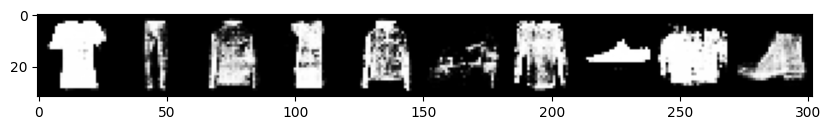

EPOCH 004 finalized: discriminator loss 0.003470 - gererator loss 0.002165, time 411.934884s


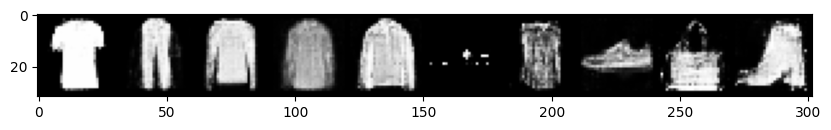

EPOCH 005 finalized: discriminator loss 0.003596 - gererator loss 0.001989, time 514.050807s


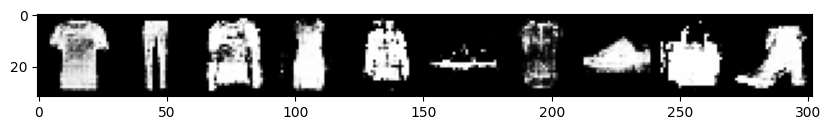

EPOCH 006 finalized: discriminator loss 0.003502 - gererator loss 0.002445, time 616.528884s


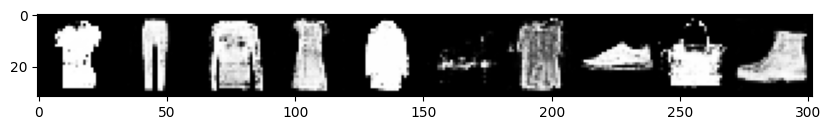

EPOCH 007 finalized: discriminator loss 0.003308 - gererator loss 0.002197, time 719.842368s


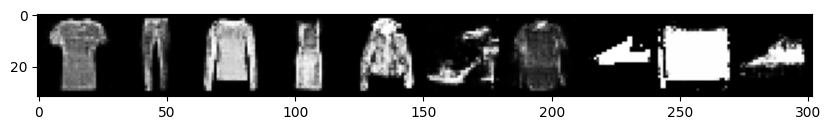

EPOCH 008 finalized: discriminator loss 0.003164 - gererator loss 0.002092, time 822.443606s


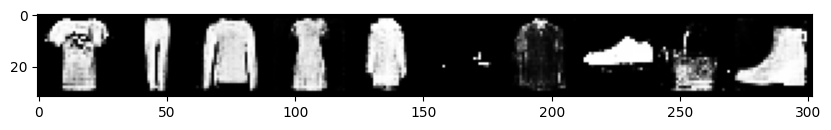

EPOCH 009 finalized: discriminator loss 0.003532 - gererator loss 0.001837, time 924.820235s


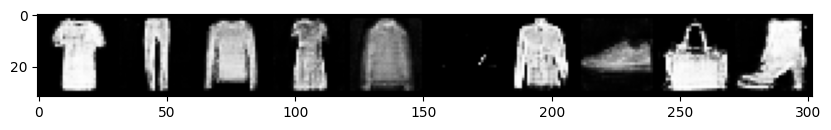

EPOCH 010 finalized: discriminator loss 0.003291 - gererator loss 0.001884, time 1028.015161s


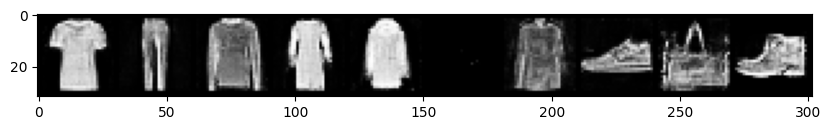

Model saved to ACGAN2_G_10.pth


In [22]:
EPOCHS = 10
gLoss = dict()
dLoss = dict()
startTime = datetime.now()
for epoch in range(0,EPOCHS):
    D_running_loss = 0
    G_running_loss = 0
    
    for idx, (images,labels) in enumerate(train_loader,0):
        
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
                
        # ---------------------
        #         disc
        # ---------------------
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = D(images)       
        
        errD_real_val = G_criterion(pvalidity, validity_label)            
        errD_real_label = D_criterion(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = G(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = D(fakes.detach())       
        
        errD_fake_val = G_criterion(pvalidity, validity_label)
        errD_fake_label = D_criterion(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
    
        
        # ------------------------
        #      gen
        # ------------------------
        
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = G(noise,sample_labels)
        pvalidity,plabels = D(fakes)
        
        errG_val = G_criterion(pvalidity, validity_label)        
        errG_label = D_criterion(plabels, sample_labels)
        
        errG = errG_val + errG_label
        errG.backward()
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        
        D_running_loss += errD.item()
        G_running_loss += errG.item()
        
        D_running_loss /= len(train_loader)
        G_running_loss /= len(train_loader)
        
        gLoss[epoch] = G_running_loss
        dLoss[epoch] = D_running_loss
  
    if (epoch + 1) % 1 == 0:
        endTime = datetime.now()
        duration = (endTime - startTime).total_seconds()
        # print the loss after each epoch
        print('EPOCH {:03d} finalized: discriminator loss {:03.6f} - gererator loss {:03.6f}, time {:03.6f}s'.format(epoch + 1, D_running_loss, G_running_loss, duration))
        
        # display 10 generated images
        random = torch.randn(10, 100).to(device)
        random_labels = np.array([i for _ in range(1) for i in range(10)])
        random_labels = torch.from_numpy(random_labels).int().to(device)
        output  = G.forward(random, random_labels).unsqueeze(1).data.to(device)
        output = output.view(10, 1, 28, 28)
        grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(grid)
        plt.show()
        
savePath = 'ACGAN2_G_10.pth'
torch.save(G, savePath)
print('Model saved to {}'.format(savePath))

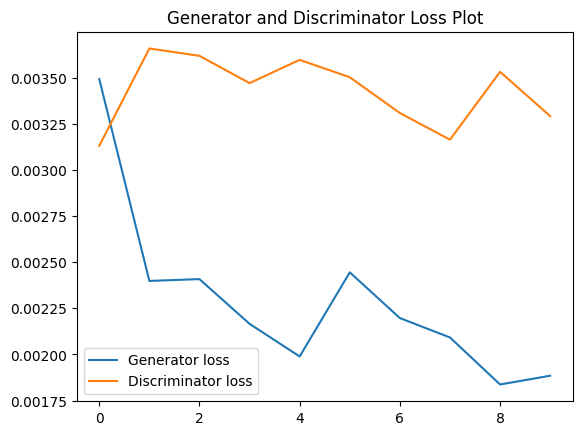

In [23]:
plt.title("Generator and Discriminator Loss Plot")
plt.plot(gLoss.keys(),gLoss.values(), label="Generator loss")
plt.plot(dLoss.keys(),dLoss.values(), label="Discriminator loss")
plt.legend()
plt.show()

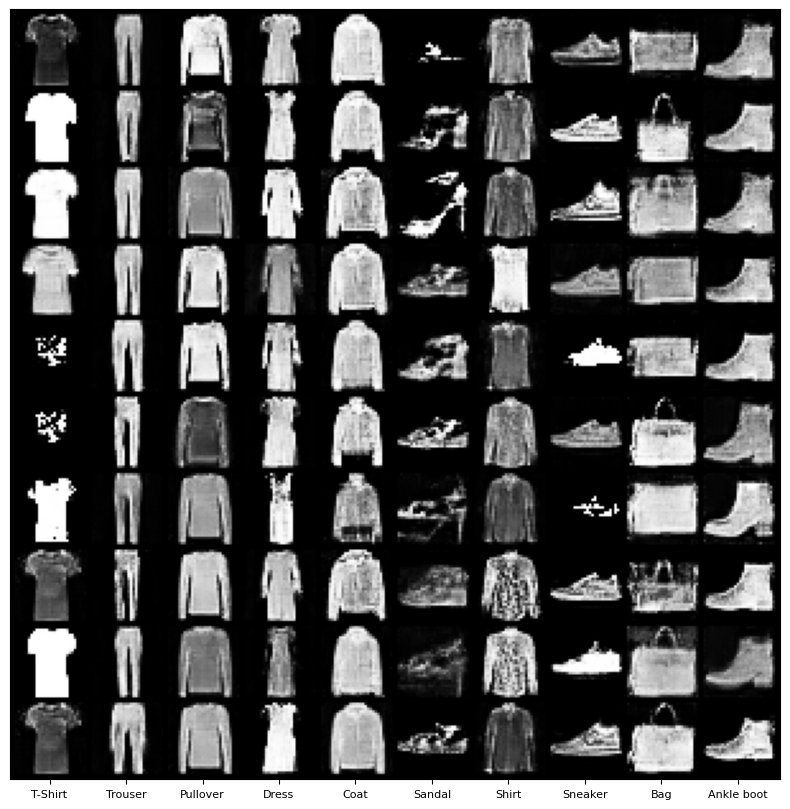

In [56]:
# savePath = 'ACGAN2_G_10.pth'
loadPath = savePath
# loadPath = 'ACGAN_G_16_20.pth'
G = torch.load(loadPath)

random = torch.randn(100, 100).to(device)

random_labels = np.array([i for _ in range(10) for i in range(10)])
random_labels = torch.from_numpy(random_labels).int().to(device)

G.eval()
output  = G.forward(random, random_labels).to(device).unsqueeze(1).data

output = output.view(100, 1, 28, 28)

# Show images
grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid)
a = plt.yticks([])
b = plt.xticks(np.arange(15, 300, 30), labelMap, fontsize=8)


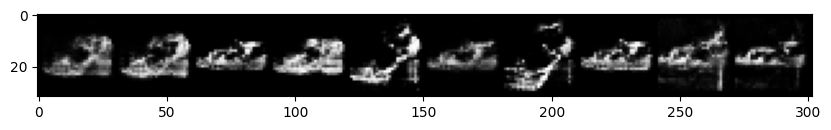

In [39]:
# generate images from a label
def generateFromLabel(inG, inLabel, inNum):
    random = torch.randn(inNum, 100).to(device)
    random_labels = np.array([i for _ in range(1) for i in [inLabel]*inNum])
    random_labels = torch.from_numpy(random_labels).int().to(device)
    output  = inG.forward(random, random_labels).unsqueeze(1).data.to(device)
    output = output.view(inNum, 1, 28, 28)
    grid = make_grid(output, nrow=inNum, normalize=True).permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(figsize=(inNum,inNum))
    ax.imshow(grid)
    plt.show()

generateFromLabel(G, 5, 10)

<BarContainer object of 10 artists>

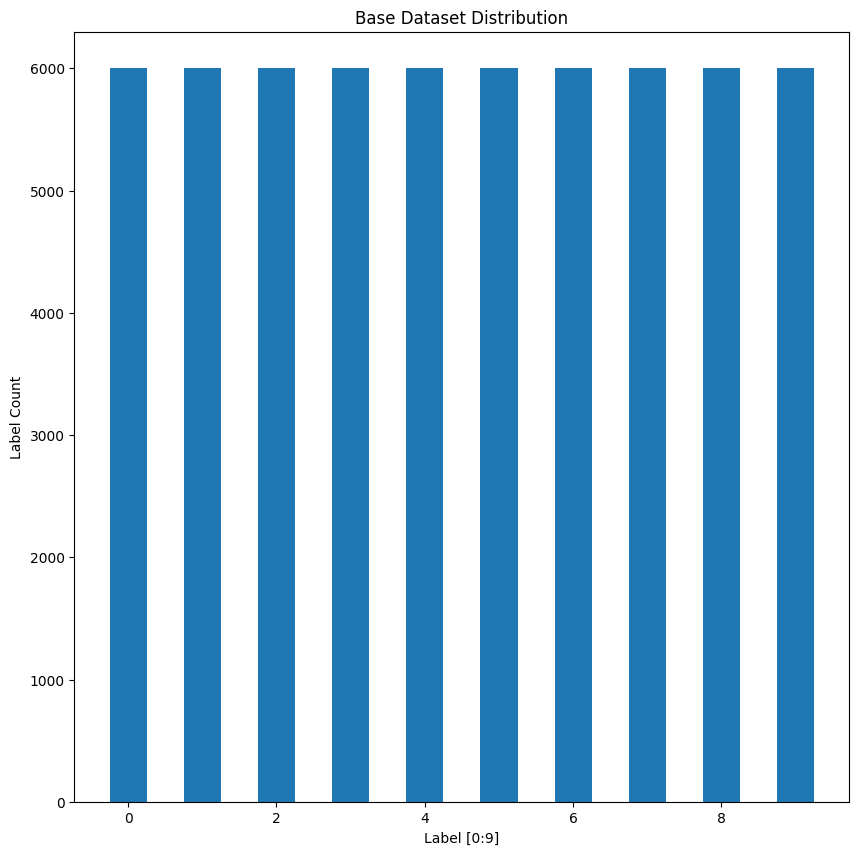

In [105]:
# Visualizations

labels = [sample.label for sample in allSamples]
keys = Counter(labels).keys()
counts = Counter(labels).values()
plt.figure(figsize=(10, 10))
plt.title("Base Dataset Distribution")
plt.xlabel("Label [0:9]")
plt.ylabel("Label Count")
plt.bar(Counter(labels).keys(),Counter(labels).values(),width=0.5)

Computing t-SNE embedding


<Figure size 2000x2000 with 0 Axes>

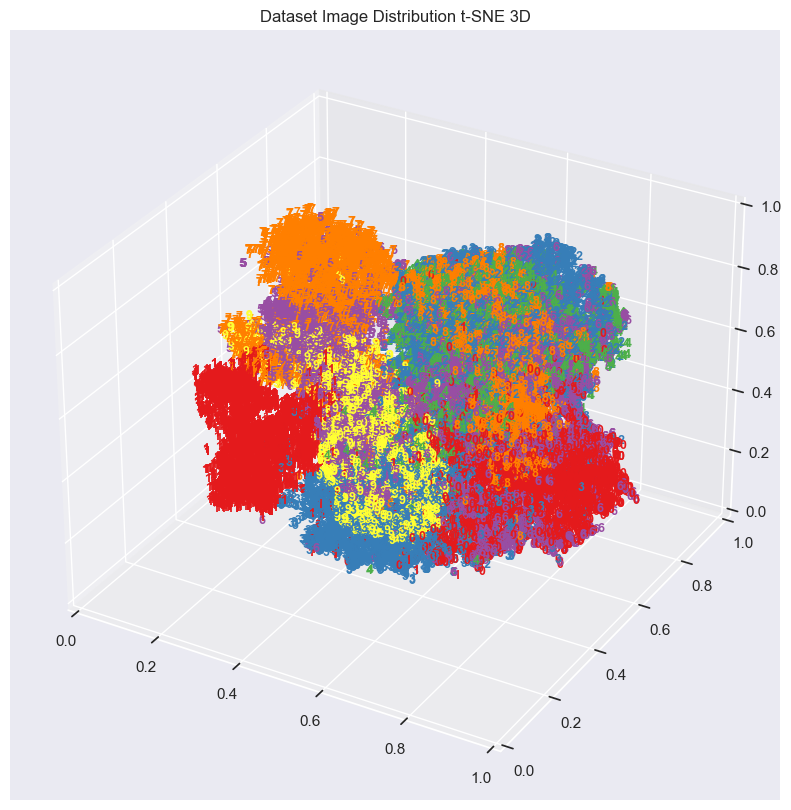

In [109]:
# check data image 3D distribution with t-NSE
X = np.array([sample.feat for sample in allSamples])
y = [sample.label for sample in allSamples]

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_o = copy.deepcopy(X)
X_tsne = tsne.fit_transform(X)

def plot_embedding_3d(X, title=None):
    plt.figure(figsize=(20, 20))    
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]), color=plt.cm.Set1(y[i] / 15.), fontdict={'weight': 'bold', 'size': 9})
        if title is not None:
            plt.title(title)

plot_embedding_3d(X_tsne,"Dataset Image Distribution t-SNE 3D")

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_84140/1049182640.py:12: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')


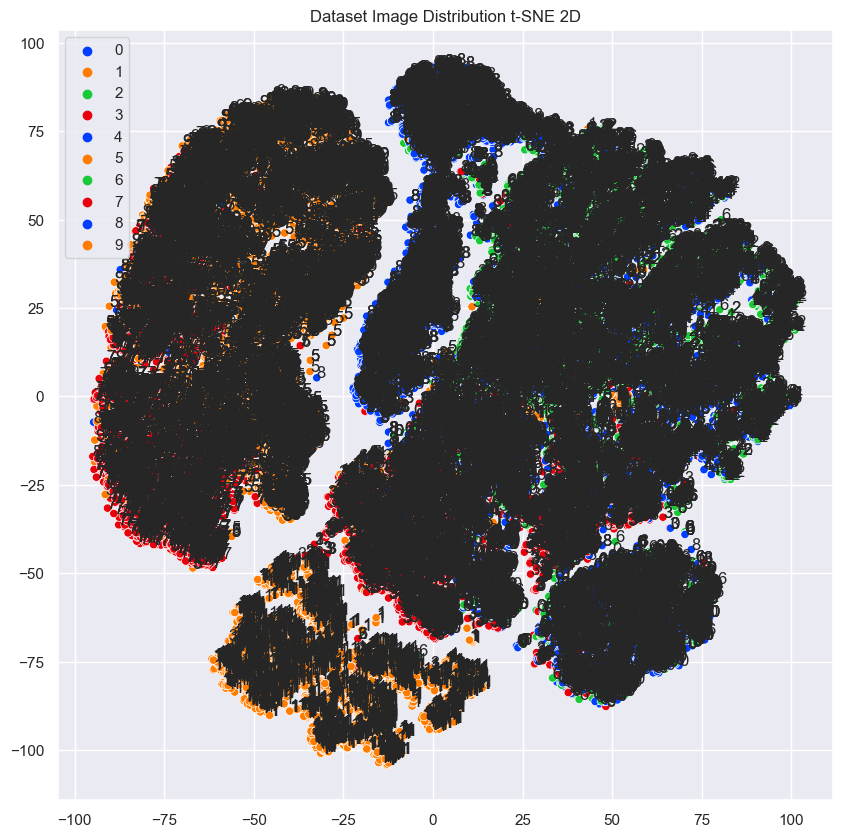

In [107]:
# check dataset pixcel feature 2D distribution with t-NSE

sns.set(rc={'figure.figsize':(10,10)}) 
palette = sns.color_palette("bright", 4) 

features = np.array([sample.feat for sample in allSamples])
labels = [sample.label for sample in allSamples]
ids = [(sample.label) for sample in allSamples]

tsne = TSNE() 
X_embedded = tsne.fit_transform(features)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')
# for i, (x, y) in enumerate(X_embedded):
#     plt.text(x, y, ids[i])

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_84140/2539749196.py:1: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')


[Text(0.5, 1.0, 'Dataset Image Distribution t-SNE 2D')]

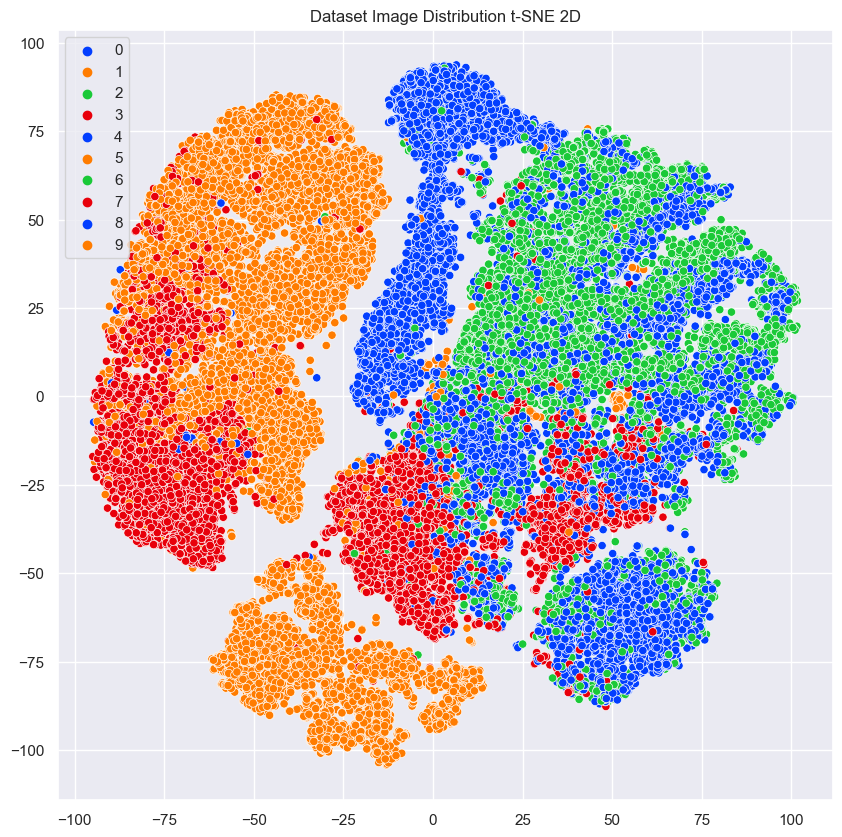

In [108]:
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')